# Random Forest From Scratch


- [Lab 1: Credit Default Dataset ](#Uploading-Credit-Default-Dataset:)
- [Lab 2: Random Forest from Scratch](#Building-Random-Forest-from-Scratch:)
- [Lab 3: Sklearn: Random Forest](#Sklearn)




#### A big part of machine learning is classification — we want to know what class (a.k.a. credit default) observation belongs to.  

#### First, before building random forest model, we must build Decision trees classification. Decision trees are a popular supervised learning method for a variety of reasons. Benefits of decision trees include that they can be used for both regression and classification, they are easy to interpret and they don’t require feature scaling.

#### The credit default data is made up and it is not applicable on any actual company. I'm interested in predicting whether an individual will default on his or her credit card payment, on the basis of annual income and monthly credit card balance. The statistical methods that I'm following through are based from "An Introduction to Statistical Learning with Applications in R"

## Uploading Credit Default Dataset:

In [43]:

from __future__ import division, print_function
import numpy as np
import math
import progressbar
bar_widgets = [
    'Training: ', progressbar.Percentage(), ' ', progressbar.Bar(marker="-", left="[", right="]"),
    ' ', progressbar.ETA()
]

import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale 
%matplotlib inline

import math
import sys


# In R, I exported the dataset from package 'ISLR' to an Excel file
df = pd.read_excel('Default-Copy1.xlsx')

# Note: factorize() returns two objects: a label array and an array with the unique values.
# We are only interested in the first object. 

df['student2'] = df.student.factorize()[0]
df['default2'] = df.default.factorize()[0]

df.drop(df.columns[[0,1]], axis = 1 , inplace = True)

df.head(3)

# removing zero LTI 
#df = df[df['LTI']!= 0]
df.head(3)

# Random shuffle the dataset
from sklearn.utils import shuffle

df  = df[0:3000]

df = shuffle(df)


dataset = df.values

random.seed(100)
#dataset = np.random.shuffle(dataset)


'''max_num_X = np.amax(dataset[:, 0:-1])
max_num_Y = np.amax(dataset[:, -1])
'''
# Split into train and test sets
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# split labels and datas
def create_dataset(dataset):
    dataX, dataY = [], []
    for i in range(int(len(dataset))):
        rowX = dataset[i, 0:-1].astype('float32')  #/max_num_X # Normalized X
        rowy = dataset[i, -1]
        dataX.append(rowX)
        dataY.append(rowy)
    return np.asarray(dataX), np.asarray(dataY)

X_train, y_train = create_dataset(train)
X_test, y_test = create_dataset(test)



## Building Random Forest from Scratch:




#### We are trying to predict whether a customer defaults on their credit cards. 

In [4]:
def calculate_entropy(y):
    """ Calculate the entropy of label array y """
    log2 = lambda x: math.log(x) / math.log(2)
    unique_labels = np.unique(y)
    entropy = 0
    for label in unique_labels:
        count = len(y[y == label])
        p = count / len(y)
        entropy += -p * log2(p)
    return entropy


def accuracy_score(y_true, y_pred):
    """ Compare y_true to y_pred and return the accuracy """
    accuracy = np.sum(y_true == y_pred, axis=0) / len(y_true)
    return accuracy


def mean_squared_error(y_true, y_pred):
    """ Returns the mean squared error between y_true and y_pred """
    mse = np.mean(np.power(y_true - y_pred, 2))
    return mse


def calculate_variance(X):
    """ Return the variance of the features in dataset X """
    mean = np.ones(np.shape(X)) * X.mean(0)
    n_samples = np.shape(X)[0]
    variance = (1 / n_samples) * np.diag((X - mean).T.dot(X - mean))
    
    return variance

def shuffle_data(X, y, seed=None):
    """ Random shuffle of the samples in X and y """
    if seed:
        np.random.seed(seed)
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    return X[idx], y[idx]


def train_test_split(X, y, test_size=0.5, shuffle=True, seed=None):
    """ Split the data into train and test sets """
    if shuffle:
        X, y = shuffle_data(X, y, seed)
    # Split the training data from test data in the ratio specified in
    # test_size
    split_i = len(y) - int(len(y) // (1 / test_size))
    X_train, X_test = X[:split_i], X[split_i:]
    y_train, y_test = y[:split_i], y[split_i:]

    return X_train, X_test, y_train, y_test 

def normalize(X, axis=-1, order=2):
    """ Normalize the dataset X """
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)


def standardize(X):
    """ Standardize the dataset X """
    X_std = X
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    for col in range(np.shape(X)[1]):
        if std[col]:
            X_std[:, col] = (X_std[:, col] - mean[col]) / std[col]
    # X_std = (X - X.mean(axis=0)) / X.std(axis=0)
    return X_std


def get_random_subsets(X, y, nth_subsets, replacements=True):
    """ Return random subsets (with replacements) of the data """
    n_samples = np.shape(X)[0]
    # Concatenate x and y and do a random shuffle
    X_y = np.concatenate((X, y.reshape((1, len(y))).T), axis=1)
    np.random.shuffle(X_y)
    subsets = []

    # Uses 50% of training samples without replacements
    subsample_size = int(n_samples // 2)
    if replacements:
        subsample_size = n_samples      # 100% with replacements

    for _ in range(nth_subsets):
        idx = np.random.choice(
            range(n_samples),
            size=np.shape(range(subsample_size)),
            replace=replacements)
        X = X_y[idx][:, :-1]
        y = X_y[idx][:, -1]
        subsets.append([X, y])
    return subsets
        
def divide_on_feature(X, feature_index, threshold):
    """ Divide dataset based on if sample value on feature index is larger than
        the given threshold """
    split_func = None
    if isinstance(threshold, int) or isinstance(threshold, float):
        split_func = lambda sample: sample[feature_index] >= threshold
    else:
        split_func = lambda sample: sample[feature_index] == threshold

    X_1 = np.array([sample for sample in X if split_func(sample)])
    X_2 = np.array([sample for sample in X if not split_func(sample)])

    return np.array([X_1, X_2])

In [5]:
class DecisionNode():
    """Class that represents a decision node or leaf in the decision Tree
    Parameters:
    -----------
    Feature_Index: int
        Feature index which we want to use as the Threshold measure.
    Threshold: float
        The Value that we will compare feature Values at Feature_Index against to
        determine the prediction.
    Value: float
        The class prediction if classification Tree, or float Value if regression Tree.
    Branch_True: DecisionNode
        Next decision node for samples where features Value met the Threshold.
    Branch_False: DecisionNode
        Next decision node for samples where features Value did not meet the Threshold.
    """
    def __init__(self, Feature_Index=None, Threshold=None,
                 Value=None, Branch_True=None, Branch_False=None):
        self.Feature_Index = Feature_Index          # Index for the feature that is tested
        self.Threshold = Threshold          # Threshold Value for feature
        self.Value = Value                  # Value if the node is a leaf in the Tree
        self.Branch_True = Branch_True      # 'Left' subTree
        self.Branch_False = Branch_False    # 'Right' subTree


# Super class of RegressionTree and ClassificationTree
class DecisionTree(object):
    """Super class of RegressionTree and ClassificationTree.
    Parameters:
    -----------
    Minimum_Samples_Split: int
        The minimum number of samples needed to make a split when building a Tree.
    
    Minimum_Impurity: float
        The minimum impurity required to split the Tree further.
    
    Max_Depth: int
        The maximum depth of a Tree.
    
    Loss: function
        Loss function that is used for Gradient Boosting models to calculate impurity.
    """
    def __init__(self, Minimum_Samples_Split=2, Minimum_Impurity=1e-7,
                 Max_Depth=float("inf"), Loss=None):
        
        self.Root = None  # Root node in dec. Tree
        
        # Minimum n of samples to justify split
        self.Minimum_Samples_Split = Minimum_Samples_Split
        
        # The minimum impurity to justify split
        self.Minimum_Impurity = Minimum_Impurity
        
        # The maximum depth to grow the Tree to
        self.Max_Depth = Max_Depth
        
        # Function to calculate impurity (classif.=>info gain, regr=>variance reduct.)
        self._Impurity_Calculation = None
        
        # Function to determine prediction of y at leaf
        self._Leaf_Value_Calculation = None
        
        # If y is one-hot encoded (multi-dim) or not (one-dim)
        self.One_Dim = None
        
        # If Gradient Boost
        self.Loss = Loss

    def fit(self, X, y, Loss=None):
        """ Build decision Tree """
        self.One_Dim = len(np.shape(y)) == 1
        self.Root = self._Build_Tree(X, y)
        self.Loss=None

    def _Build_Tree(self, X, y, current_depth=0):
        """ Recursive method which builds out the decision Tree and splits X and respective y
        on the feature of X which (based on impurity) best separates the data"""

        Largest_Impurity = 0
        
        Best_Criteria = None    # Feature index and Threshold
        
        Best_Subsets = None        # Subsets of the data

        # Check if expansion of y is needed
        if len(np.shape(y)) == 1:
            y = np.expand_dims(y, axis=1)

        # Add y as last column of X
        Xy = np.concatenate((X, y), axis=1)

        n_samples, n_features = np.shape(X)

        if n_samples >= self.Minimum_Samples_Split and current_depth <= self.Max_Depth:
            # Calculate the impurity for each feature
            for Feature_Index in range(n_features):
                # All Values of Feature_Index
                Feature_Values = np.expand_dims(X[:, Feature_Index], axis=1)
                Unique_Values = np.unique(Feature_Values)

                # Iterate through all unique Values of feature column i and
                # calculate the impurity
                for Threshold in Unique_Values:
                    # Divide X and y depending on if the feature Value of X at index Feature_Index
                    # meets the Threshold
                    Xy1, Xy2 = divide_on_feature(Xy, Feature_Index, Threshold)

                    if len(Xy1) > 0 and len(Xy2) > 0:
                        # Select the y-Values of the two sets
                        y1 = Xy1[:, n_features:]
                        y2 = Xy2[:, n_features:]

                        # Calculate impurity
                        impurity = self._Impurity_Calculation(y, y1, y2)

                        # If this Threshold resulted in a higher information gain than previously
                        # recorded save the Threshold Value and the feature
                        # index
                        if impurity > Largest_Impurity:
                            Largest_Impurity = impurity
                            Best_Criteria = {"Feature_Index": Feature_Index, "Threshold": Threshold}
                            Best_Subsets = {
                                "leftX": Xy1[:, :n_features],   # X of left subTree
                                "lefty": Xy1[:, n_features:],   # y of left subTree
                                "rightX": Xy2[:, :n_features],  # X of right subTree
                                "righty": Xy2[:, n_features:]   # y of right subTree
                                }

        if Largest_Impurity > self.Minimum_Impurity:
            # Build subTrees for the right and left branches
            Branch_True = self._Build_Tree(Best_Subsets["leftX"], Best_Subsets["lefty"], current_depth + 1)
            Branch_False = self._Build_Tree(Best_Subsets["rightX"], Best_Subsets["righty"], current_depth + 1)
            return DecisionNode(Feature_Index=Best_Criteria["Feature_Index"], Threshold=Best_Criteria[
                                "Threshold"], Branch_True=Branch_True, Branch_False=Branch_False)

        # We're at leaf => determine Value
        leaf_Value = self._Leaf_Value_Calculation(y)

        return DecisionNode(Value=leaf_Value)


    def (self, x, Tree=None):
        """ Do a recursive search down the Tree and make a prediction of the data sample by the
            Value of the leaf that we end up at """

        if Tree is None:
            Tree = self.Root

        # If we have a Value (i.e we're at a leaf) => return Value as the prediction
        if Tree.Value is not None:
            return Tree.Value

        # Choose the feature that we will test
        Feature_Value = x[Tree.Feature_Index]

        # Determine if we will follow left or right branch
        branch = Tree.Branch_False
        if isinstance(Feature_Value, int) or isinstance(Feature_Value, float):
            if Feature_Value >= Tree.Threshold:
                branch = Tree.Branch_True
        elif Feature_Value == Tree.Threshold:
            branch = Tree.Branch_True

        # Test subTree
        return self.(x, branch)

    def predict(self, X):
        """ Classify samples one by one and return the set of labels """
        y_pred = [self.(sample) for sample in X]
        return y_pred

    def Print_Tree(self, Tree=None, indent=" "):
        """ Recursively print the decision Tree """
        if not Tree:
            Tree = self.Root

        # If we're at leaf => print the label
        if Tree.Value is not None:
            print (Tree.Value)
        # Go deeper down the Tree
        else:
            # Print test
            print ("%s:%s? " % (Tree.Feature_Index, Tree.Threshold))
            # Print the true scenario
            print ("%sT->" % (indent), end="")
            self.Print_Tree(Tree.Branch_True, indent + indent)
            # Print the false scenario
            print ("%sF->" % (indent), end="")
            self.Print_Tree(Tree.Branch_False, indent + indent)

class ClassificationTree(DecisionTree):
    def _Calculate_Information_Gain(self, y, y1, y2):
        # Calculate information gain
        p = len(y1) / len(y)
        entropy = calculate_entropy(y)
        info_gain = entropy - p * \
            calculate_entropy(y1) - (1 - p) * \
            calculate_entropy(y2)

        return info_gain

    def _Majority_Vote(self, y):
        most_common = None
        max_count = 0
        for label in np.unique(y):
            # Count number of occurences of samples with label
            count = len(y[y == label])
            if count > max_count:
                most_common = label
                max_count = count
        return most_common

    def fit(self, X, y):
        self._Impurity_Calculation = self._Calculate_Information_Gain
        self._Leaf_Value_Calculation = self._Majority_Vote
        super(ClassificationTree, self).fit(X, y)

In [6]:
class RandomForest():
    """Random Forest classifier. Uses a collection of classification trees that
    trains on random subsets of the data using a random subsets of the features.
    Parameters:
    -----------
    N_Classification_Trees: int
        The number of classification trees that are used.
        
    Maximum_Features: int
        The maximum number of features that the classification trees are allowed to
        use.
        
    Minimum_Samples_Split: int
        The minimum number of samples needed to make a split when building a tree.
        
    Minimum_Gain: float
        The minimum impurity required to split the tree further. 
        
    Maximum_Depth: int
        The maximum depth of a tree.
    """
    def __init__(self, N_Classification_Trees=100, Maximum_Features=None, Minimum_Samples_Split=2,
                 Minimum_Gain=0, Maximum_Depth= 10):
        
        self.N_Classification_Trees = N_Classification_Trees    # Number of trees
        
        self.Maximum_Features = Maximum_Features    # Maxmimum number of features per tree
        
        self.Minimum_Samples_Split = Minimum_Samples_Split
        
        self.Minimum_Gain = Minimum_Gain            # Minimum information gain req. to continue
        
        self.Maximum_Depth = Maximum_Depth          # Maximum depth for tree
        
        self.progressbar = progressbar.ProgressBar(widgets=bar_widgets)

        # Initialize decision trees
        self.trees = []
        for _ in range(N_Classification_Trees):
            self.trees.append(
                ClassificationTree(
                    Minimum_Samples_Split=self.Minimum_Samples_Split,
                    Minimum_Impurity=Minimum_Gain,
                    Maximum_Depth=self.Maximum_Depth))

    def fit(self, X, y):
        
        Nth_Features = np.shape(X)[1]
        # If Maximum_Features have not been defined => select it as
       
        # sqrt(Nth_Features)
        if not self.Maximum_Features:
            self.Maximum_Features = int(math.sqrt(Nth_Features))

        # Choose one random subset of the data for each tree
        subsets = get_random_subsets(X, y, self.N_Classification_Trees)

        for i in self.progressbar(range(self.N_Classification_Trees)):
            
            X_subset, y_subset = subsets[i]
            
            # Feature bagging (select random subsets of the features)
            idx = np.random.choice(range(Nth_Features), size=self.Maximum_Features, replace=True)
            
            # Save the indices of the features for prediction
            self.trees[i].feature_indices = idx
            
            # Choose the features corresponding to the indices
            X_subset = X_subset[:, idx]
            
            # Fit the tree to the data
            self.trees[i].fit(X_subset, y_subset)

    def predict(self, X):
        
        y_preds = np.empty((X.shape[0], len(self.trees)))
        
        # Let each tree make a prediction on the data
        
        for i, tree in enumerate(self.trees):
            
            # Indices of the features that the tree has trained on
            idx = tree.feature_indices
            
            # Make a prediction based on those features
            prediction = tree.predict(X[:, idx])
            y_preds[:, i] = prediction
            
        y_pred = []
        
        # For each sample
        for sample_predictions in y_preds:
            
            # Select the most common class prediction
            y_pred.append(np.bincount(sample_predictions.astype('int')).argmax())
        
        return y_pred

In [8]:
from __future__ import division, print_function
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from sklearn import datasets

def main():
    data = datasets.load_digits()
    X = data.data
    y = data.target

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, seed=2)

    clf = RandomForest(n_estimators=100)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)

    print ("Accuracy:", accuracy)
    
    df_ = pd.DataFrame({'True default status': y_test,
                    'Predicted default status': y_pred})
    df_.replace(to_replace={0:'No', 1:'Yes'}, inplace=True)

    df_.groupby(['Predicted default status','True default status']).size().unstack('True default status')
        #Plot().plot_in_2d(X_test, y_pred, title="rf", accuracy=accuracy)
    print(df_.groupby(['Predicted default status','True default status']).size().unstack('True default status'))
    print(classification_report(y_test, y_pred))

    #Plot().plot_in_2d(X_test, y_pred, title="Random Forest", accuracy=accuracy, legend_labels=data.target_names)


if __name__ == "__main__":
    main()

Training: 100% [------------------------------------------------] Time: 0:03:54


Accuracy: 0.9610027855153204
True default status          2     3     4     5     6     7     8     9  \
Predicted default status                                                   
2                         76.0   NaN   NaN   NaN   NaN   NaN   3.0   NaN   
3                          1.0  65.0   NaN   1.0   NaN   NaN   1.0   3.0   
4                          NaN   NaN  80.0   NaN   NaN   NaN   NaN   NaN   
5                          NaN   NaN   NaN  61.0   NaN   NaN   2.0   NaN   
6                          NaN   NaN   NaN   1.0  60.0   NaN   1.0   NaN   
7                          NaN   NaN   NaN   NaN   NaN  75.0   1.0   1.0   
8                          NaN   NaN   NaN   NaN   NaN   NaN  62.0   1.0   
9                          NaN   1.0   NaN   NaN   NaN   NaN   NaN  69.0   
No                         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
Yes                        NaN   1.0   1.0   NaN   1.0   1.0   6.0   NaN   

True default status         No   Yes  
Predicted default s

/Users/michael/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/Users/michael/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


(array([ 333.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2667.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

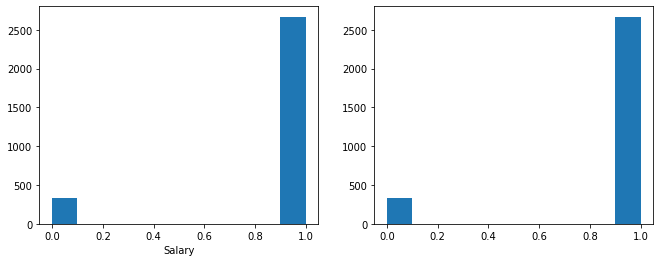

In [46]:
X = df[['balance','income']].as_matrix() #  'Age', 'LTI','Months Delayed', 'student2' df[['balance','income', 'Age', 'LTI','Months Delayed', 'student2']].values 
y =  df.default2.values #np.log(df.default2.as_matrix())

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,4))
ax1.hist(df.default2.as_matrix())
ax1.set_xlabel('Salary')
ax2.hist(y)
#ax2.set_xlabel('Log(Salary)');



In [9]:
from sklearn.metrics import confusion_matrix, classification_report

In [47]:

def main(X_train, X_test, y_train, y_test):

    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, seed=3)

    # Fit and predict using rf
    rf = RandomForest(n_estimators=100)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)

    print ("Accuracy:", accuracy)
    df_ = pd.DataFrame({'True default status': y_test,
                    'Predicted default status': y_pred})
    df_.replace(to_replace={0:'No', 1:'Yes'}, inplace=True)

    df_.groupby(['Predicted default status','True default status']).size().unstack('True default status')
        #Plot().plot_in_2d(X_test, y_pred, title="rf", accuracy=accuracy)
    print(df_.groupby(['Predicted default status','True default status']).size().unstack('True default status'))
    print(classification_report(y_test, y_pred))

if __name__ == "__main__":
    main(X_train, X_test, y_train, y_test)
    


Training: 100% [------------------------------------------------] Time: 0:29:16


Accuracy: 0.8893333333333333
True default status       No  Yes
Predicted default status         
Yes                       83  667
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        83
         1.0       0.89      1.00      0.94       667

    accuracy                           0.89       750
   macro avg       0.44      0.50      0.47       750
weighted avg       0.79      0.89      0.84       750



/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### The Random forest from scratch can only support credit defaults who did defaulted with overall accuracy of 89%

#### Now lets try the Sklearn package to compare the results and hypertune the parameters

## Sklearn: 

In [48]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier

# random forest model creation
clf = RandomForestClassifier(n_estimators= 100)

#clf = DecisionTreeClassifier(max_depth=None, max_leaf_nodes=6, max_features=3)


#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=8675309)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)


print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.63      0.59      0.61        83
         1.0       0.95      0.96      0.95       667

    accuracy                           0.92       750
   macro avg       0.79      0.77      0.78       750
weighted avg       0.91      0.92      0.91       750



#### The Sklearn was faster the accuracy score has improved by 91%. Now lets see we can improve the model by implementing the hyper parameters within RandomForestClassifier...

In [51]:
import pydot
from IPython.display import Image
from sklearn.externals.six import StringIO  

#cols = df.columns[3:9].values.tolist()

#graph, = print_tree(clf, features= cols)
#Image(graph.create_png())

#graph2, = print_tree(clf, features=cols, class_names=['No', 'Yes'])
#Image(graph2.create_png())

cm = pd.DataFrame(confusion_matrix(y_test, pred).T, index=['No', 'Yes'], columns=['No', 'Yes'])
cm.index.name = 'Predicted'
cm.columns.name = 'True'
cm

True,No,Yes
Predicted,,
No,49,29
Yes,34,638


In [52]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

clf_cv_score = cross_val_score(clf, X, y, cv=10, scoring='roc_auc')

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, pred))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, pred))
print('\n')
print("=== All AUC Scores ===")
print(clf_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", clf_cv_score.mean())

=== Confusion Matrix ===
[[ 49  34]
 [ 29 638]]


=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.63      0.59      0.61        83
         1.0       0.95      0.96      0.95       667

    accuracy                           0.92       750
   macro avg       0.79      0.77      0.78       750
weighted avg       0.91      0.92      0.91       750



=== All AUC Scores ===
[0.92999559 0.86257986 0.91848425 0.91294972 0.96487345 0.91016911
 0.93337873 0.87707906 0.92971064 0.93643199]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.9175652408876745


In [53]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(clf.get_params())

from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

Parameters currently in use:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [54]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune

import time
t0 = time.time()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)


t1 = time.time()

total = t1-t0
print("Time in Minutes:",total/60)

[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=   1.3s
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=   1.4s
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=   1.4s
[CV] n_estimators=1200, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1200, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False, total=   5.2s
[CV] n_estimators=1200, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True, total=   7.1s
[CV] n_estimators=1200, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True, total=   7.4s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True, total=   7.6s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1200, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False, total=   5.7s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1200, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False, total=   5.8s
[CV] n_estimators=1600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False, total=   9.1s
[CV] n_estimators=1600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False, total=   9.2s
[CV] n_estimators=1600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True, total=   5.8s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=30, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False, total=   8.7s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=30, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=30, bootstrap=False, total=   3.2s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=30, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True, total=   5.3s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=100, bootstrap=False 
[CV]  n_estimators=1600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True, total=   5.6s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=100, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=30, bootstrap=False, total=   3.6s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=100, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=30, bootstrap=False, total=   4.0s
[CV] n_estimators=600, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1000, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=100, bootstrap=False, total=   5.4s


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV] n_estimators=600, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1000, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=100, bootstrap=False, total=   5.1s
[CV] n_estimators=600, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=False 
[CV]  n_estimators=600, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=False, total=   3.1s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=50, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1000, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=100, bootstrap=False, total=   5.4s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=50, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=600, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=False, total=   3.7s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=50, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=600, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=False, total=   3.9s
[CV] n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=50, bootstrap=False, total=   6.5s
[CV] n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=50, bootstrap=False, total=   6.2s
[CV] n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=50, bootstrap=False, total=   5.2s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=70, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=70, bootstrap=True, total=   1.1s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=70, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=70, bootstrap=True, total=   1.1s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=70, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=False, total=   7.5s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=70, bootstrap=True, total=   1.2s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=False, total=   6.6s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=False, total=   6.4s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False 


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   42.9s
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False, total=   3.1s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False, total=   3.1s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False, total=   3.1s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False, total=   7.0s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False, total=   7.2s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False, total=   5.6s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False, total=   7.2s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=False, total=   2.9s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=False, total=   3.0s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False, total=   5.9s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False, total=   6.0s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=30, bootstrap=False, total=   3.2s
[CV] n_estimators=600, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=70, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=600, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=70, bootstrap=False, total=   2.1s
[CV] n_estimators=600, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=70, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, total=   6.4s
[CV] n_estimators=600, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=70, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=600, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=70, bootstrap=False, total=   2.2s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, total=   6.6s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=600, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=70, bootstrap=False, total=   2.3s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, total=   6.5s
[CV] n_estimators=1800, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=110, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True, total=   3.1s
[CV] n_estimators=1800, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=110, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True, total=   3.2s
[CV] n_estimators=1800, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=110, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True, total=   3.2s
[CV] n_estimators=600, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=80, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=600, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=80, bootstrap=True, total=   1.7s
[CV] n_estimators=600, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=80, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1800, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=110, bootstrap=False, total=   6.6s
[CV] n_estimators=600, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=80, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=80, bootstrap=True, total=   1.8s
[CV] n_estimators=1800, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1800, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=110, bootstrap=False, total=   6.4s
[CV] n_estimators=1800, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=600, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=80, bootstrap=True, total=   1.9s
[CV] n_estimators=1800, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=110, bootstrap=False, total=   6.6s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1800, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=False, total=   6.4s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1800, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=False, total=   6.5s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1600, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=False, total=   5.9s
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1800, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=False, total=   6.7s
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True, total=   4.0s
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1600, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=False, total=   6.0s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True, total=   4.4s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1600, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=False, total=   7.5s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True, total=   6.6s
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, total=   8.1s
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, total=   8.0s
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, total=   7.5s
[CV] n_estimators=400, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=400, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=False, total=   1.8s
[CV] n_estimators=400, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False, total=   6.5s
[CV] n_estimators=400, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=400, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=False, total=   1.5s
[CV] n_estimators=1400, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=40, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=400, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=False, total=   1.8s
[CV] n_estimators=1400, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=40, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False, total=   6.4s
[CV] n_estimators=1400, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=40, bootstrap=False 
[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False, total=   6.7s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1000, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True, total=   4.3s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1400, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=40, bootstrap=False, total=   7.3s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1400, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=40, bootstrap=False, total=   7.1s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False 
[CV]  n_estimators=1400, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=40, bootstrap=False, total=   7.3s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1000, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True, total=   3.5s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1000, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True, total=   3.6s
[CV] n_estimators=1200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True, total=   4.9s
[CV] n_estimators=1200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False, total=   9.0s
[CV] n_estimators=1200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False, total=   9.0s
[CV] n_estimators=1200, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False, total=   9.1s
[CV] n_estimators=1200, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True, total=   4.9s
[CV] n_estimators=1200, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True, total=   5.0s
[CV] n_estimators=800, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1200, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=False, total=   6.3s
[CV] n_estimators=800, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1200, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=False, total=   6.7s
[CV] n_estimators=800, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=False, total=   5.0s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1200, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=False, total=   7.3s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=False, total=   5.0s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=False, total=   5.2s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=False, total=   5.0s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=False, total=   4.9s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=False, total=   4.5s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=True, total=   3.0s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=True, total=   2.5s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=True, total=   2.5s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False, total=   3.3s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True, total=   5.8s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True, total=   5.8s
[CV] n_estimators=1200, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True, total=   5.9s
[CV] n_estimators=1200, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False, total=   3.6s
[CV] n_estimators=1200, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False, total=   4.0s
[CV] n_estimators=800, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=100, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1200, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True, total=   5.5s
[CV] n_estimators=800, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=100, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1200, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True, total=   5.8s
[CV] n_estimators=800, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=100, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=100, bootstrap=True, total=   3.9s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1200, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True, total=   6.2s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=100, bootstrap=True, total=   4.0s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=100, bootstrap=True, total=   4.7s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=60, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, total=   4.6s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=60, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, total=   5.0s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=60, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, total=   5.1s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=True, total=   1.3s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=True, total=   1.0s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=60, bootstrap=True, total=   5.7s
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=60, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=True, total=   0.7s
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=60, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=60, bootstrap=True, total=   5.7s
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=60, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=60, bootstrap=True, total=   4.6s
[CV] n_estimators=800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=60, bootstrap=True, total=   1.9s
[CV] n_estimators=800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=60, bootstrap=True, total=   1.9s
[CV] n_estimators=800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=60, bootstrap=True, total=   2.0s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True, total=   1.1s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True, total=   2.5s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True, total=   2.5s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True, total=   2.5s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True, total=   1.4s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True, total=   1.3s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=False, total=   0.8s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=False, total=   0.9s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=False, total=   0.9s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True, total=   3.1s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True, total=   3.2s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True, total=   3.2s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=False, total=   1.4s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=False, total=   1.4s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True, total=   6.1s
[CV] n_estimators=1200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=False, total=   1.5s
[CV] n_estimators=1200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True, total=   6.1s
[CV] n_estimators=1200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True, total=   6.3s
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False, total=   4.8s
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=False, total=   2.7s
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False, total=   4.8s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=False, total=   2.9s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=False 
[CV]  n_estimators=1200, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False, total=   5.8s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=110, bootstrap=False, total=   3.5s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=50, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=False, total=  10.0s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=50, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=False, total=   9.2s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=50, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=20, bootstrap=False, total=   9.1s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=50, bootstrap=False, total=   9.0s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False 


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.1min
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, total=   3.4s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, total=   3.7s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=50, bootstrap=False, total=   8.0s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=50, bootstrap=False, total=   8.1s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, total=   4.3s
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False, total=   4.1s
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False, total=   3.6s
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False, total=   3.6s
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=60, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=False, total=   5.1s
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=60, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=60, bootstrap=False, total=   2.1s
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=60, bootstrap=False 
[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=False, total=   5.1s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=60, bootstrap=False, total=   2.2s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=False, total=   5.3s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=60, bootstrap=False, total=   2.3s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=80, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1600, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True, total=   6.5s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=80, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1600, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True, total=   6.8s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=80, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1600, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True, total=   7.0s
[CV] n_estimators=1400, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=100, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=80, bootstrap=True, total=   7.5s
[CV] n_estimators=1400, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=100, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=80, bootstrap=True, total=   5.9s
[CV] n_estimators=1400, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=100, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1400, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=100, bootstrap=True, total=   4.3s
[CV] n_estimators=1400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=80, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1400, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=100, bootstrap=True, total=   4.3s
[CV] n_estimators=1400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=80, bootstrap=True 
[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=80, bootstrap=True, total=   5.9s
[CV] n_estimators=1400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=80, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1400, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=100, bootstrap=True, total=   7.3s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=True 
[CV]  n_estimators=1400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=80, bootstrap=True, total=   7.1s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=True, total=   1.0s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=80, bootstrap=True, total=   7.7s
[CV] n_estimators=400, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=True, total=   1.3s
[CV] n_estimators=400, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=80, bootstrap=True, total=   8.0s
[CV] n_estimators=400, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=True, total=   1.2s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=400, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True, total=   1.7s
[CV]  n_estimators=400, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True, total=   1.7s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=False 
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=400, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True, total=   1.7s
[CV] n_estimators=1200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=False, total=   5.5s
[CV] n_estimators=1200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=False, total=   5.4s
[CV] n_estimators=1200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=False, total=   5.6s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False, total=   6.1s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False, total=   4.6s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False, total=   4.3s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True, total=   4.7s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True, total=   4.8s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True, total=   5.7s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1600, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, total=   6.1s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1600, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, total=   6.5s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1600, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, total=   7.7s
[CV] n_estimators=1400, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=70, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=False, total=   8.9s
[CV] n_estimators=1400, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=70, bootstrap=True 
[CV]  n_estimators=1400, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=70, bootstrap=True, total=   4.7s
[CV] n_estimators=1400, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=70, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=False, total=   8.7s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=False, total=   8.4s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1400, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=70, bootstrap=True, total=   4.7s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False, total=   3.9s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=60, bootstrap=False 
[CV]  n_estimators=1400, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=70, bootstrap=True, total=   4.7s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=60, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False, total=   4.0s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=60, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False, total=   4.1s
[CV] n_estimators=1400, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=60, bootstrap=False, total=   7.6s
[CV] n_estimators=1400, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=60, bootstrap=False, total=   7.6s
[CV] n_estimators=1400, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=60, bootstrap=False, total=   7.8s
[CV] n_estimators=800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1400, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=False, total=   5.8s
[CV] n_estimators=800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=False, total=   3.4s
[CV] n_estimators=800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=False, total=   3.0s
[CV] n_estimators=1800, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=60, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1400, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=False, total=   5.9s
[CV] n_estimators=1800, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=60, bootstrap=True 
[CV]  n_estimators=1400, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=False, total=   6.0s
[CV] n_estimators=1800, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=60, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=False, total=   3.4s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=90, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=90, bootstrap=False, total=   1.6s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=90, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=90, bootstrap=False, total=   1.5s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=90, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=60, bootstrap=True, total=   6.0s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=90, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1800, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=60, bootstrap=True, total=   6.1s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=90, bootstrap=True 
[CV]  n_estimators=1800, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=60, bootstrap=True, total=   6.1s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=90, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=90, bootstrap=False, total=   1.8s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False, total=   2.1s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False, total=   2.0s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1600, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=90, bootstrap=True, total=   6.2s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1600, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=90, bootstrap=True, total=   6.3s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False, total=   1.7s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=90, bootstrap=True, total=   6.3s
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=True, total=   5.2s
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=True, total=   5.1s
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=True, total=   5.1s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True, total=   6.5s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1000, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True, total=   3.0s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1000, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True, total=   3.2s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=True, total=   0.7s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=True 
[CV]  n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True, total=   6.6s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=True, total=   0.8s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=60, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=True, total=   0.9s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=60, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True, total=   3.8s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=60, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True, total=   7.4s
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=100, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=100, bootstrap=True, total=   2.1s
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=100, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=100, bootstrap=True, total=   1.8s
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=100, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=100, bootstrap=True, total=   3.0s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=60, bootstrap=False, total=   9.6s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=True 
[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=60, bootstrap=False, total=   9.5s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=True 
[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=60, bootstrap=False, total=   9.8s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=True, total=   6.1s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=True, total=   6.6s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=True, total=   6.8s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False, total=   6.6s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False, total=   5.5s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False, total=   5.1s
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False, total=   4.9s
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False, total=   4.9s
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=False, total=   4.9s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False, total=   3.8s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False, total=   3.8s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False, total=   3.9s
[CV] n_estimators=1600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True, total=   2.2s
[CV] n_estimators=1600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True, total=   2.4s
[CV] n_estimators=1600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True, total=   2.4s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=100, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=100, bootstrap=True, total=   3.6s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=100, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True, total=   8.0s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=100, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True, total=   8.2s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True, total=   7.9s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=100, bootstrap=True, total=   4.3s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=100, bootstrap=True, total=   4.7s
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True, total=   6.2s
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True, total=   6.2s
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True, total=   6.4s
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True, total=   4.0s
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True, total=   2.9s
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True, total=   2.5s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True, total=   3.1s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True, total=   4.7s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=2000, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False, total=  11.5s
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=40, bootstrap=True 
[CV]  n_estimators=2000, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False, total=  11.5s
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=40, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=2000, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=None, bootstrap=False, total=  12.2s
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=40, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=40, bootstrap=True, total=   3.1s
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=30, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=True, total=   4.9s
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=30, bootstrap=False 
[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=40, bootstrap=True, total=   3.2s
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=30, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=40, bootstrap=True, total=   2.5s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=40, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=30, bootstrap=False, total=   2.7s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=40, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=30, bootstrap=False, total=   2.7s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=40, bootstrap=False 
[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=30, bootstrap=False, total=   2.7s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=40, bootstrap=False, total=   1.9s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=40, bootstrap=False, total=   1.9s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=40, bootstrap=False, total=   1.8s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False, total=   0.7s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False, total=   0.7s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False, total=   0.8s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False, total=   4.1s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False, total=   4.1s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False, total=   4.1s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=40, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True, total=   8.8s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=40, bootstrap=True 
[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True, total=   8.7s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=40, bootstrap=True 


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True, total=   8.7s


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=40, bootstrap=True, total=   8.4s


/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=40, bootstrap=True, total=   5.6s
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=40, bootstrap=True, total=   5.7s


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.1min finished


Time in Minutes: 365.6696710586548


In [57]:
# print results
print(rf_random.best_params_)

{'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 70, 'bootstrap': True}


In [58]:
rfc = RandomForestClassifier(n_estimators= 400,min_samples_split = 10 , min_samples_leaf = 4, 
                             max_features= 'auto', max_depth = 70, bootstrap = True )
rfc.fit(X_train,y_train)
rfc_predict = rfc.predict(X_test)
rfc_cv_score = cross_val_score(rfc, X, y, cv=10, scoring='roc_auc')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[ 50  33]
 [ 25 642]]


=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.67      0.60      0.63        83
         1.0       0.95      0.96      0.96       667

    accuracy                           0.92       750
   macro avg       0.81      0.78      0.79       750
weighted avg       0.92      0.92      0.92       750



=== All AUC Scores ===
[0.94139678 0.90306235 0.94448116 0.91828396 0.97911701 0.93962093
 0.95743956 0.89957849 0.94190021 0.95716564]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.9382046101956005


### The model improved by ~2.0% which is impressive for the credit default data. 

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf =  DecisionTreeClassifier() # RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)